## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## First, I'll compute the camera calibration using chessboard images

In [71]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt

In [72]:
def debugg(s):
    if (true):
        print(s)

In [73]:
def getCalibrateMtx(): 
    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((6*9,3), np.float32)
    objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.

    # Make a list of calibration images
    images = glob.glob('camera_cal/calibration*.jpg')
    img_size = cv2.imread(images[0]).shape[1::-1]

    # Step through the list and search for chessboard corners
    for fname in images:
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)

    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)

    return mtx, dist

mtx, dist = getCalibrateMtx()
# dst = cv2.undistort(img, mtx, dist, None, mtx)

def distCorrection(img):
    return cv2.undistort(img, mtx, dist, None, mtx)

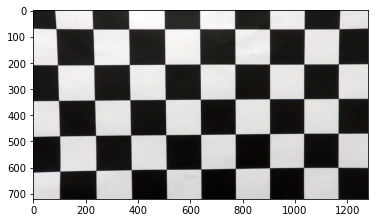

In [74]:
cali = plt.imread('camera_cal/calibration1.jpg')
undistored_cali = distCorrection(cali)
plt.imshow(undistored_cali)
# plt.imsave("writeup_imgs/undist_cali.jpg", undistored_cali)

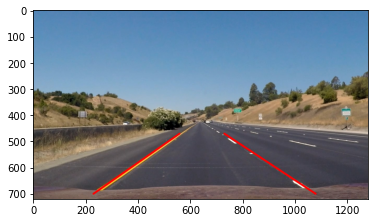

In [75]:
def matchLaneLines():
    # Pick lines for getting perspective transformation matrix
    straight = plt.imread("test_images/straight_lines1.jpg")
    cv2.line(straight, (560, 470), (230, 700), color=(255,0,0), thickness=5)
    cv2.line(straight, (730, 470), (1080, 700), color=(255,0,0), thickness=5)
    plt.imshow(straight)
    # plt.imsave('writeup_imgs/matched_p_trans_points.jpg', straight)
matchLaneLines()

Note: don't pick points too far away, pixels far away will get way more distorted after prespective transformation

In [76]:
def getPerspectiveM(image_shape):
    # Leave some margin on the left, right side
    margin = 300
    
    src = np.float32([[560, 470], [730, 470], [230, 700], [1080, 700]])
    dst = np.float32([[margin, 0],
                     [image_shape[1]-margin, 0],
                     [margin, image_shape[0]],
                     [image_shape[1]-margin, image_shape[0]]])
    print (dst)
    
    return cv2.getPerspectiveTransform(src, dst), cv2.getPerspectiveTransform(dst, src)

perM, invM = getPerspectiveM(straight.shape)

def prespetiveTransform(img):
    return cv2.warpPerspective(img, perM, (img.shape[1], img.shape[0]), flags=cv2.INTER_LINEAR)

[[300.   0.]
 [980.   0.]
 [300. 720.]
 [980. 720.]]


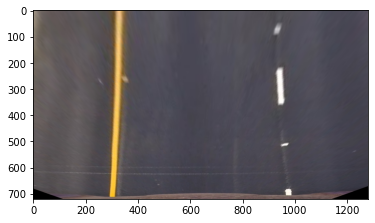

In [77]:
trans = prespetiveTransform(plt.imread("test_images/straight_lines1.jpg"))
plt.imshow(trans)
# plt.imsave('writeup_imgs/straight_line_p_transform.jpg', trans)

In [78]:
# Input should be undistored images from previous step, should be read with plt.imread() -- RGB

def vertical_grad_thresh(img, sobel_kernel=3, thresh=(30, 100)):
    # Apply the following steps to img
    # 1) Convert to grayscale
    # 2) Take the derivative in x or y given orient = 'x' or 'y'
    # 3) Take the absolute value of the derivative or gradient
    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    # 5) Create a mask of 1's where the scaled gradient magnitude 
            # is > thresh_min and < thresh_max
    # 6) Return this mask as your binary_output image
    
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    abs_sobel = np.absolute(sobel)
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    
    sxbin = np.zeros_like(scaled_sobel)
    sxbin[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    
    return sxbin

In [79]:
# direction of gradient

def dir_grad_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Apply the following steps to img
    # 1) Convert to grayscale
    # 2) Take the gradient in x and y separately
    # 3) Take the absolute value of the x and y gradients
    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
    # 5) Create a binary mask where direction thresholds are met
    # 6) Return this mask as your binary_output image
    
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    grad_dir = np.arctan2(np.absolute(sobely), np.absolute(sobelx)) # note it's acrtan2(y, x)
    
    grad_bin = np.zeros_like(grad_dir)
    grad_bin[(grad_dir >= thresh[0]) & (grad_dir <= thresh[1])] = 1
    
    return grad_bin

In [80]:
def gray_color_threshold(img, thresh=(30, 100)):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    gray_bin = np.zeros_like(gray)
    gray_bin[(gray >= thresh[0]) & (gray <= thresh[1])] = 1
    
    return gray_bin

In [81]:
def hls_color_threshold(img, s_thresh=(170, 255), h_thresh=(15, 100)):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    H = hls[:,:,0]
    S = hls[:,:,2]

    hs_bin = np.zeros_like(H)
    hs_bin[((S >= s_thresh[0]) & (S <= s_thresh[1])) & ((H >= h_thresh[0]) & (H <= h_thresh[1]))] = 1

    return hs_bin

In [82]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):

        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     

        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        
        # was the line detected in the last iteration?
        self.detected = False  
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]
        self.last_n_fits = []
        
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float')
        self.maxdiff = [0,0,0]
        
        #x values for detected line pixels
        self.allx_curr = []
        self.anchor_x = np.array([], dtype='float')

        #y values for detected line pixels
        self.ally_curr = []
        self.anchor_y = np.array([], dtype='float')
        
        # x value where the current fitted line intersect with bottom of the image
        self.basex = 0
        
    def save(self):
        self.allx_prev = self.allx_curr
        self.ally_prev = self.ally_curr
    
    def allx(self):
        return np.int32(np.concatenate((self.allx_curr, self.anchor_x)))

    def ally(self):
        return np.int32(np.concatenate((self.ally_curr, self.anchor_y)))
    
    def updateFit(self, newfit):
        self.last_n_fits.append(newfit)
        if (len(self.last_n_fits) > 5):
            self.last_n_fits.pop(0)
        self.current_fit = newfit
        self.best_fit = np.mean(self.last_n_fits, axis=0)
        
    def updateAnchorPoints(self):
        self.anchor_x = self.best_fit[0] * self.anchor_y ** 2 + self.best_fit[1] * self.anchor_y + self.best_fit[2]


In [83]:
def slidingWindow(binary_warped, left_lane, right_lane):
    
#     out_img = np.dstack((binary_warped, binary_warped, binary_warped)) * 255

    nonzero = binary_warped.nonzero()
    nonzerox = np.array(nonzero[1])
    nonzeroy = np.array(nonzero[0])
    
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:, :], axis=0)
    
    midpoint = histogram.shape[0] // 2
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    nwindows = 9
    margin = 100
    minpix = 50
    
    y_total = binary_warped.shape[0]
    window_h = y_total // nwindows
    
    prev_leftx = leftx_base
    prev_rightx = rightx_base
    
    left_lane_inds = []
    right_lane_inds = []
    
    for w in range(nwindows):
        miny = y_total - (w+1) * window_h
        maxy = y_total - w * window_h
        
        left_minx = prev_leftx - margin
        left_maxx = prev_leftx + margin
        
        right_minx = prev_rightx - margin
        right_maxx = prev_rightx + margin
        
        left_filter = (nonzerox >= left_minx) & (nonzerox <= left_maxx) & (nonzeroy >= miny) & (nonzeroy <= maxy)
        right_filter = (nonzerox >= right_minx) & (nonzerox <= right_maxx) & (nonzeroy >= miny) & (nonzeroy <= maxy)
        
        left_nonzero_x = nonzerox[left_filter]
        right_nonzero_x = nonzerox[right_filter]
        
        left_pix_count = len(left_nonzero_x)
        right_pix_count = len(right_nonzero_x)
        
#         cv2.rectangle(out_img, (left_minx, miny), (left_maxx, maxy), color=(255,0,0), thickness=5)
#         cv2.rectangle(out_img, (right_minx, miny), (right_maxx, maxy), color=(255,0,0), thickness=5)
    
        if (left_pix_count > minpix):
            prev_leftx = np.mean(left_nonzero_x, dtype=np.int32)
        if (right_pix_count > minpix):
            prev_rightx = np.mean(right_nonzero_x, dtype=np.int32)

        left_lane_inds.append(np.argwhere(left_filter).flatten().tolist())
        right_lane_inds.append(np.argwhere(right_filter).flatten().tolist())
    
#     plt.imshow(out_img)
#     plt.imsave('writeup_imgs/5.sliding_window.jpg', out_img)

    left_all_inds = np.int32(np.concatenate(left_lane_inds))
    right_all_inds = np.int32(np.concatenate(right_lane_inds))
    
    left_lane.allx_curr = nonzerox[left_all_inds]
    left_lane.ally_curr = nonzeroy[left_all_inds]

    right_lane.allx_curr = nonzerox[right_all_inds]
    right_lane.ally_curr = nonzeroy[right_all_inds]
    
    maxy = binary_warped.shape[0]
    
    left_fit = fitLine(left_lane, maxy)
    right_fit = fitLine(right_lane, maxy)
        
    left_lane.updateFit(left_fit)
    right_lane.updateFit(right_fit)
    
    return left_lane, right_lane

In [84]:
def searchAroundLanes(binary_warped, lane1, lane2):
    margin = 50
    left_lane_inds = []
    right_lane_inds = []
    
    nonzero = binary_warped.nonzero()
    nonzerox = np.array(nonzero[1])
    nonzeroy = np.array(nonzero[0])
    
    left_fit = lane1.best_fit
    right_fit = lane2.best_fit
    
    left_x = np.zeros_like(nonzeroy)
    left_x = left_fit[0] * nonzeroy ** 2 + left_fit[1] * nonzeroy + left_fit[2]
    left_lane_around_poly_bin = np.logical_and(left_x >= nonzerox - margin, left_x <= nonzerox + margin)
    left_lane_inds = np.argwhere(left_lane_around_poly_bin).flatten().tolist()
    
    right_x = np.zeros_like(nonzeroy)
    right_x = right_fit[0] * nonzeroy ** 2 + right_fit[1] * nonzeroy + right_fit[2]
    right_lane_around_poly_bin = np.logical_and(right_x >= nonzerox - margin, right_x <= nonzerox + margin)
    right_lane_inds = np.argwhere(right_lane_around_poly_bin).flatten().tolist()
    
    left_lane.save()
    right_lane.save()
    
    left_lane.allx_curr = nonzerox[left_lane_inds]
    left_lane.ally_curr = nonzeroy[left_lane_inds]
    right_lane.allx_curr = nonzerox[right_lane_inds]
    right_lane.ally_curr = nonzeroy[right_lane_inds]

    maxy = binary_warped.shape[0]
    
    left_fit = fitLine(left_lane, maxy)
    right_fit = fitLine(right_lane, maxy)
    
    left_lane.updateFit(left_fit)
    left_lane.updateAnchorPoints()
    right_lane.updateFit(right_fit)
    right_lane.updateAnchorPoints()
    
    return left_lane, right_lane

In [85]:
def drawPixelsWithLaneLines(binary_warped, left_lane, right_lane):
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255

    # Color in left and right line pixels
    out_img[left_lane.ally_curr, left_lane.allx_curr] = [255, 0, 0]
    out_img[right_lane.ally_curr, right_lane.allx_curr] = [0, 0, 255]
    
    left_fit = left_lane.best_fit
    right_fit = right_lane.best_fit

    ploty = np.int32(np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0]))
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    out_img[ploty, np.int32(left_fitx)] = [0, 255, 255]
    out_img[ploty, np.int32(right_fitx)] = [255, 255, 0]
    
    return out_img

In [86]:
# Define conversions in x and y from pixels space to meters
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
def visualize(undist, binary_warped, left_lane, right_lane):
    global xm_per_pix, ym_per_pix
   
    # Need to be the same for lane searching
    margin = 50
    
    left_fit = left_lane.best_fit
    right_fit = right_lane.best_fit

    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0])
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, invM, (undist.shape[1], undist.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    
    left_fit_cr = np.array([left_fit[0] * xm_per_pix / (ym_per_pix**2), left_fit[0] * xm_per_pix / (ym_per_pix), left_fit[2]])
    right_fit_cr = np.array([right_fit[0] * xm_per_pix / (ym_per_pix**2), right_fit[0] * xm_per_pix / (ym_per_pix), right_fit[2]])
    left_cr, right_cr = measure_curvature(undist.shape[0], left_fit_cr, right_fit_cr)
    
    lane_mid = (left_lane.basex + right_lane.basex) / 2
    car = undist.shape[1] / 2
    
    offcenter = int((car - lane_mid) * xm_per_pix * 100) / 100
    offcenter_value = abs(offcenter)
    offcenter_dir = 'right' if offcenter > 0 else 'left'
    
    font                   = cv2.FONT_HERSHEY_SIMPLEX
    bottomLeftCornerOfText = (50, 50)
    bottomLeftCornerOfTextLine2 = (50, 100)
    fontScale              = 1
    fontColor              = (255,255,255)
    lineType               = 2

    cv2.putText(result, 
        f"Radius of curvature = {(left_cr + right_cr) // 2} m.", 
        bottomLeftCornerOfText, 
        font, 
        fontScale,
        fontColor,
        lineType)
    
    cv2.putText(result, 
        f"Vehicle is {offcenter_value} m {offcenter_dir} to the center",
        bottomLeftCornerOfTextLine2, 
        font, 
        fontScale,
        fontColor,
        lineType)
        
    return result

def measure_curvature(y_val, left_fit_cr, right_fit_cr):
    global xm_per_pix, ym_per_pix
    
    left_curverad = (1+(2*left_fit_cr[0]*y_val*ym_per_pix+left_fit_cr[1])**2)**(3/2) / (2*abs(left_fit_cr[0]))
    right_curverad = (1+(2*right_fit_cr[0]*y_val*ym_per_pix+right_fit_cr[1])**2)**(3/2) / (2*abs(right_fit_cr[0]))
    
    return left_curverad, right_curverad

In [87]:
def fitLine(line, y_val):
    line.detected = True
    fit = np.polyfit(line.ally(), line.allx(), 2)
    line.basex = fit[0]*y_val**2 + fit[1]*y_val + fit[2]
    return fit

In [88]:
# Return binary warped lane pixels
def processImg(undist):
    # blur
    kernel_size = 5
    undist_blur = cv2.GaussianBlur(undist, (kernel_size, kernel_size), 0)

    # combining color, gradient methods to get binary image
    sobel_size = 15
    ver_grad_bin = vertical_grad_thresh(undist_blur, sobel_size, (20, 150))
    dir_grad_bin = dir_grad_threshold(undist_blur, sobel_size, (0.45, 1.15))
    
    gray_bin = gray_color_threshold(undist_blur, thresh=(170, 255))
    hs_bin = hls_color_threshold(undist_blur, s_thresh=(170,255), h_thresh=(10,100))
    
    combined_grad_bin = np.zeros_like(ver_grad_bin)
    combined_grad_bin[(ver_grad_bin > 0) | (dir_grad_bin > 0)] = 1
    
    combined_color_bin = np.zeros_like(gray_bin)
    combined_color_bin[(gray_bin > 0) | (hs_bin > 0)] = 1
    
    combined = np.zeros_like(gray_bin)
    combined[((ver_grad_bin > 0) & (dir_grad_bin > 0)) | ((gray_bin > 0) & (hs_bin > 0))] = 1
    
    # Perspective transformation
    rectified_lane = prespetiveTransform(combined)

    return rectified_lane

In [89]:
# Return binary warped lane pixels
def processImgWithImgLog(undist):
    # blur
    kernel_size = 5
    undist_blur = cv2.GaussianBlur(undist, (kernel_size, kernel_size), 0)

    # combining color, gradient methods to get binary image
    sobel_size = 15
    ver_grad_bin = vertical_grad_thresh(undist_blur, sobel_size, (20, 150))
    plt.imsave('writeup_imgs/4.ver_grad_bin.jpg', ver_grad_bin, cmap='gray')
    dir_grad_bin = dir_grad_threshold(undist_blur, sobel_size, (0.45, 1.15))
    plt.imsave('writeup_imgs/4.dir_grad_bin.jpg', dir_grad_bin, cmap='gray')
    
    gray_bin = gray_color_threshold(undist_blur, thresh=(170, 255))
    plt.imsave('writeup_imgs/4.gray_bin.jpg', gray_bin, cmap='gray')
    hs_bin = hls_color_threshold(undist_blur, s_thresh=(170,255), h_thresh=(10,100))
    plt.imsave('writeup_imgs/4.hs_bin.jpg', hs_bin, cmap='gray')
    
    combined_grad_bin = np.zeros_like(ver_grad_bin)
    combined_grad_bin[(ver_grad_bin > 0) | (dir_grad_bin > 0)] = 1
    plt.imsave('writeup_imgs/4.combined_grad_bin.jpg', combined_grad_bin, cmap='gray')
    
    combined_color_bin = np.zeros_like(gray_bin)
    combined_color_bin[(gray_bin > 0) | (hs_bin > 0)] = 1
    plt.imsave('writeup_imgs/4.combined_color_bin.jpg', combined_color_bin, cmap='gray')
    
    combined = np.zeros_like(gray_bin)
    combined[((ver_grad_bin > 0) & (dir_grad_bin > 0)) | ((gray_bin > 0) & (hs_bin > 0))] = 1
    plt.imsave('writeup_imgs/4.combined_bin.jpg', combined, cmap='gray')
    
    # Perspective transformation
    rectified_lane = prespetiveTransform(combined)
    plt.imsave('writeup_imgs/4.rectified.jpg', rectified_lane, cmap='gray')

    return rectified_lane

In [90]:
# # =============================================================
# test_images = glob.glob('test_images/test*.jpg')
# # test_images = glob.glob('test_images/5*.jpg')
# for fname in test_images:
#     img = plt.imread(fname)
    
#     binary_warped = processImg(img)
            
#     left_lane = Line()
#     right_lane = Line()
 
#     left_lane, right_lane = slidingWindow(binary_warped, left_lane, right_lane)
# #     left_lane, right_lane = searchAroundLanes(binary_warped, left_lane, right_lane)
#     result = visualize(binary_warped, left_lane, right_lane)
    
#     plt.imsave('output_images/' + fname.split('/')[1], result, cmap='gray')
# # =============================================================


img = plt.imread('test_images/test6.jpg')
undist = distCorrection(img)
plt.imsave('writeup_imgs/3.undist_test.jpg', undist)
binary_warped = processImgWithImgLog(undist)

left_lane = Line()
right_lane = Line()

left_lane, right_lane = slidingWindow(binary_warped, left_lane, right_lane)

lane_pix = drawPixelsWithLaneLines(binary_warped, left_lane, right_lane)
print(left_lane.best_fit)
print(right_lane.best_fit)
plt.imsave('writeup_imgs/5.lane_pixels.jpg', lane_pix)

result = visualize(undist, binary_warped, left_lane, right_lane)
plt.imsave('writeup_imgs/6.result.jpg', result)
# #     left_lane, right_lane = searchAroundLanes(binary_warped, left_lane, right_lane)
# result = visualize(binary_warped, left_lane, right_lane)

# plt.imsave('output_images/' + fname.split('/')[1], result, cmap='gray')

[ 1.30530737e-04 -2.65206759e-01  4.67350326e+02]
[-8.71795316e-05  1.03323187e-02  1.04330065e+03]


In [91]:
left_lane = Line()
right_lane = Line()

def reset():
    global left_lane, right_lane
    left_lane = Line()
    right_lane = Line()

def process_image(img):
    global left_lane, right_lane
    undist = distCorrection(img)
    binary_warped = processImg(undist)
    
    if (left_lane.detected) & (right_lane.detected):
        left_lane, right_lane = searchAroundLanes(binary_warped, left_lane, right_lane)
    else:
        # number of points sampled from previously matched lane lines to be mixed into found pixels to stablize the line.
        sample_size = 2000
        
        left_lane, right_lane = slidingWindow(binary_warped, left_lane, right_lane)
        left_lane.anchor_y = np.linspace(0, img.shape[0]-1, sample_size)
        left_lane.updateAnchorPoints()
        right_lane.anchor_y = np.linspace(0, img.shape[0]-1, sample_size)
        right_lane.updateAnchorPoints()
                
    return visualize(undist, binary_warped, left_lane, right_lane)

In [92]:
# For Testing, only return the rectified result
def rectify(img):
    # distortion correction
    undist = distCorrection(img)
    
    # blur
    kernel_size = 5
    undist_blur = cv2.GaussianBlur(undist, (kernel_size, kernel_size), 0)

    # Perspective transformation
    rectified_lane = prespetiveTransform(undist_blur)

    return rectified_lane

In [93]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [94]:
clip = VideoFileClip('project_video.mp4')
output = 'videos_output/proj.mp4'
reset()
# result_clip = clip.subclip(0,1).fl_image(process_image)
result_clip = clip.fl_image(process_image)
result_clip.write_videofile(output, audio=False)

t:   0%|          | 2/1260 [00:00<01:14, 16.86it/s, now=None]

Moviepy - Building video videos_output/proj.mp4.
Moviepy - Writing video videos_output/proj.mp4



Moviepy - Done !
Moviepy - video ready videos_output/proj.mp4
